## Final Project Submission

Please fill out:
* Student name: Matt LeRoi
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!

Business Understanding

Data Understanding

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import sqlite3
import statsmodels.formula.api as smf
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [3]:
gross=pd.read_csv("./data/bom.movie_gross.csv.gz")
gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [4]:
gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
# Convert foreign gross to a number
gross['foreign_gross'] = pd.to_numeric(gross.foreign_gross.str.replace('[,]',''))

#Foreign gross over $1 billion is listed in millions (verified by comparing this database to the budget database)
gross.loc[gross[gross['title']=='The Fate of the Furious'].index,'foreign_gross'] = 1010*1000000
gross.loc[gross[gross['title']=='Jurassic World'].index,'foreign_gross'] = 1019.4*1000000
gross.loc[gross[gross['title']=='Star Wars: The Force Awakens'].index,'foreign_gross'] = 1131.6*1000000
gross.loc[gross[gross['title']=='Furious 7'].index,'foreign_gross'] = 1163*1000000
gross.loc[gross[gross['title']=='Avengers: Infinity War'].index,'foreign_gross'] = 1369.5*1000000
gross.fillna(0, inplace=True)

gross['worldwide_gross'] = gross.domestic_gross + gross.foreign_gross

In [6]:
budget = pd.read_csv("./data/tn.movie_budgets.csv.gz")
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [8]:
# Convert $ columns to numbers
budget.production_budget = pd.to_numeric(budget.production_budget.str.replace('[$,]',''))
budget.domestic_gross = pd.to_numeric(budget.domestic_gross.str.replace('[$,]',''))
budget.worldwide_gross = pd.to_numeric(budget.worldwide_gross.str.replace('[$,]',''))

In [9]:
# Creating columns for release month, release year, profit (based on worldwide gross), and ROI (Return on Invenstment, as %)
budget['month']= pd.to_datetime(budget['release_date']).dt.month_name()
budget['year']= pd.to_datetime(budget['release_date']).dt.year
budget['profit'] = budget.worldwide_gross - budget.production_budget
budget['roi'] = 100*budget.profit/budget.production_budget

In [10]:
# Drop all entries that show zero worldwide gross as irrelevant
budget.drop(budget[budget['worldwide_gross'] == 0].index, inplace=True)

In [11]:
conn = sqlite3.connect("./data/im.db") # Open a connection to IMDB file
cursor = conn.cursor() # Initialize cursor

# SQL query to join movie akas, basics, and ratings tables for further analysis

imdb_query = """SELECT *, movie_akas.movie_id as mv_id
                FROM movie_akas 
                join movie_ratings on movie_akas.movie_id = movie_ratings.movie_id
                join movie_basics on movie_akas.movie_id = movie_basics.movie_id
                ;"""

imdb = pd.read_sql(imdb_query, conn)

# Dropping duplicate movie_id columns (leaving the mv_id column I renamed) and "title" column.
imdb.drop(['movie_id','title'],axis = 1, inplace=True)

In [12]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261806 entries, 0 to 261805
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ordering           261806 non-null  int64  
 1   region             218341 non-null  object 
 2   language           37080 non-null   object 
 3   types              153268 non-null  object 
 4   attributes         12924 non-null   object 
 5   is_original_title  261806 non-null  float64
 6   averagerating      261806 non-null  float64
 7   numvotes           261806 non-null  int64  
 8   primary_title      261806 non-null  object 
 9   original_title     261806 non-null  object 
 10  start_year         261806 non-null  int64  
 11  runtime_minutes    250553 non-null  float64
 12  genres             260621 non-null  object 
 13  mv_id              261806 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 28.0+ MB


In [13]:
imdb.head()

,ordering,region,language,types,attributes,is_original_title,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,mv_id
0,10,BG,bg,None,None,0.0,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",tt0369610
1,11,JP,None,imdbDisplay,None,0.0,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",tt0369610
2,12,BR,None,imdbDisplay,None,0.0,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",tt0369610
3,13,BR,None,None,short title,0.0,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",tt0369610
4,14,FR,None,imdbDisplay,None,0.0,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",tt0369610


In [14]:
# Remove redundant rows with same unique identifier
imdb.drop_duplicates(subset=['mv_id'], inplace=True) 

# The unique identifier from IMDB doesn't appear in the budget or gross databases, so I will
# have to use something else. The title alone has a significant number of duplicates, so
# I'm using the combination of title and start year to join the databases. Removing the rows
# in which both are duplicated (773 of 6191) is deemed an acceptable loss of data.
imdb.drop_duplicates(subset=['primary_title','start_year'], inplace=True) 

In [15]:
# Add columns for genres
# I'm creating columns for each genre and listing it as 
# true or false if it applies to each film. In the
# model, I will see which genres have the highest effect on 
# sales and if certain combinations have particular effects.

def add_genre_column (single_genre):
    imdb[single_genre] = imdb['genres'].str.contains(single_genre)

genre_list = []
for value in imdb['genres'].str.split(','):
    if value is not None:
        genre_list.extend(value)
genre_list = list(set(genre_list))
        
for x in genre_list:
    add_genre_column(x)
# Rename columns with dashes in them
imdb.rename(columns={'Game-Show': 'Game_Show', 'Reality-TV': 'Reality_TV', 'Sci-Fi' : 'Sci_Fi'}, inplace=True)
genre_list = [g.replace('-', '_') for g in genre_list]
imdb

,ordering,region,language,types,attributes,is_original_title,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,mv_id,Biography,Action,War,Western,Music,Reality_TV,History,Game_Show,Adventure,Crime,Comedy,News,Adult,Documentary,Drama,Sci_Fi,Family,Mystery,Romance,Musical,Animation,Sport,Thriller,Horror,Fantasy
0,10,BG,bg,None,None,0.0,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",tt0369610,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
48,1,GB,None,None,None,0.0,7.6,23,Cloud Cuckoo Land,Cloud Cuckoo Land,2012,92.0,Drama,tt0381957,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
49,10,UA,None,None,None,0.0,6.6,241792,John Carter,John Carter,2012,132.0,"Action,Adventure,Sci-Fi",tt0401729,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
83,1,None,None,original,None,1.0,7.0,5,Versailles Rediscovered - The Sun King's Vanis...,Versailles Rediscovered - The Sun King's Vanis...,2019,52.0,Documentary,tt10010134,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
86,1,IN,None,None,None,0.0,8.3,30,Vinara sodara veera kumara,Vinara sodara veera kumara,2019,NaN,"Drama,Romance",tt10084780,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261792,1,DE,None,None,None,0.0,5.2,5,Der Atem,Der Atem,2019,95.0,Documentary,tt9644084,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
261795,1,XWW,en,imdbDisplay,None,0.0,6.0,16,Homing,Querência,2019,90.0,Drama,tt9657946,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
261798,1,DE,None,imdbDisplay,None,0.0,6.7,35,Anderswo. Allein in Afrika,Anderswo. Allein in Afrika,2018,103.0,"Adventure,Documentary",tt9723084,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
261800,1,CN,yue,imdbDisplay,None,0.0,6.0,6,Monkey King: The Volcano,Monkey King: The Volcano,2019,90.0,"Action,Adventure,Comedy",tt9726638,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [16]:
# Set index of each dataframe to the movie title and year, then rename for consistency.

gross.set_index(['title','year'], inplace=True)
budget.set_index(['movie','year'], inplace=True)
imdb.set_index(['primary_title','start_year'], inplace=True)
imdb.index.rename(['title','year'], inplace=True)
budget.index.rename(['title','year'], inplace=True)

In [17]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 69032 entries, ('Jurassic World', 2015) to ('Farewell Song', 2019)
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ordering           69032 non-null  int64  
 1   region             57684 non-null  object 
 2   language           5652 non-null   object 
 3   types              23961 non-null  object 
 4   attributes         2003 non-null   object 
 5   is_original_title  69032 non-null  float64
 6   averagerating      69032 non-null  float64
 7   numvotes           69032 non-null  int64  
 8   original_title     69032 non-null  object 
 9   runtime_minutes    62330 non-null  float64
 10  genres             68397 non-null  object 
 11  mv_id              69032 non-null  object 
 12  Biography          68397 non-null  object 
 13  Action             68397 non-null  object 
 14  War                68397 non-null  object 
 15  Western            68397 non-

In [18]:
imdb_gross = pd.concat([imdb, gross], axis=1, join="inner")
imdb_budget = pd.concat([imdb, budget], axis=1, join="inner")

In [19]:
imdb_gross

,,ordering,region,language,types,attributes,is_original_title,averagerating,numvotes,original_title,runtime_minutes,genres,mv_id,Biography,Action,War,Western,Music,Reality_TV,History,Game_Show,Adventure,Crime,Comedy,News,Adult,Documentary,Drama,Sci_Fi,Family,Mystery,Romance,Musical,Animation,Sport,Thriller,Horror,Fantasy,studio,domestic_gross,foreign_gross,worldwide_gross
title,year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Jurassic World,2015,10,BG,bg,None,None,0.0,7.0,539338,Jurassic World,124.0,"Action,Adventure,Sci-Fi",tt0369610,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,Uni.,652300000.0,1.019400e+09,1.671700e+09
John Carter,2012,10,UA,None,None,None,0.0,6.6,241792,John Carter,132.0,"Action,Adventure,Sci-Fi",tt0401729,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,BV,73100000.0,2.111000e+08,2.842000e+08
From Paris with Love,2010,10,EE,None,None,None,0.0,6.5,107079,From Paris with Love,92.0,"Action,Crime,Thriller",tt1179034,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGF,24100000.0,2.870000e+07,5.280000e+07
The Bourne Legacy,2012,10,RS,None,None,None,0.0,6.7,268678,The Bourne Legacy,135.0,"Action,Adventure,Thriller",tt1194173,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,Uni.,113200000.0,1.629000e+08,2.761000e+08
Limitless,2011,10,AR,None,imdbDisplay,None,0.0,7.4,492490,Limitless,105.0,"Mystery,Sci-Fi,Thriller",tt1219289,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,Rela.,79200000.0,8.260000e+07,1.618000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Man Who Invented Christmas,2017,10,PT,None,imdbDisplay,None,0.0,7.0,9430,The Man Who Invented Christmas,104.0,"Biography,Comedy,Drama",tt6225520,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,BST,5700000.0,0.000000e+00,5.700000e+06
Poster Boys,2017,1,IN,None,None,None,0.0,5.6,1234,Poster Boys,128.0,Comedy,tt6352548,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Sony,97000.0,2.400000e+06,2.497000e+06
Bending the Arc,2017,1,US,None,None,None,0.0,8.1,93,Bending the Arc,102.0,Documentary,tt6370266,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,Abr.,21900.0,0.000000e+00,2.190000e+04


In [20]:
# Adding runtime for those I found manually and removing entries for those I couldn't
imdb_budget.loc['Burlesque','runtime_minutes']=119
imdb_budget.drop(imdb_budget[imdb_budget['original_title'].str.contains('The Promise')].index, inplace=True)
imdb_budget.sort_values('roi')
imdbudget_adj = imdb_budget.drop(imdb_budget[imdb_budget['original_title'].str.contains('Gallows')].index)
imdbudget_adj

,,ordering,region,language,types,attributes,is_original_title,averagerating,numvotes,original_title,runtime_minutes,genres,mv_id,Biography,Action,War,Western,Music,Reality_TV,History,Game_Show,Adventure,Crime,Comedy,News,Adult,Documentary,Drama,Sci_Fi,Family,Mystery,Romance,Musical,Animation,Sport,Thriller,Horror,Fantasy,id,release_date,production_budget,domestic_gross,worldwide_gross,month,profit,roi
title,year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Jurassic World,2015,10,BG,bg,None,None,0.0,7.0,539338,Jurassic World,124.0,"Action,Adventure,Sci-Fi",tt0369610,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,34,"Jun 12, 2015",215000000,652270625,1648854864,June,1433854864,666.909239
John Carter,2012,10,UA,None,None,None,0.0,6.6,241792,John Carter,132.0,"Action,Adventure,Sci-Fi",tt0401729,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,14,"Mar 9, 2012",275000000,73058679,282778100,March,7778100,2.828400
Alice in Wonderland,2010,10,IE,en,imdbDisplay,None,0.0,6.5,358813,Alice in Wonderland,108.0,"Adventure,Family,Fantasy",tt1014759,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,51,"Mar 5, 2010",200000000,334191110,1025491110,March,825491110,412.745555
The Bourne Legacy,2012,10,RS,None,None,None,0.0,6.7,268678,The Bourne Legacy,135.0,"Action,Adventure,Thriller",tt1194173,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,76,"Aug 10, 2012",125000000,113203870,280355920,August,155355920,124.284736
Limitless,2011,10,AR,None,imdbDisplay,None,0.0,7.4,492490,Limitless,105.0,"Mystery,Sci-Fi,Thriller",tt1219289,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,91,"Mar 18, 2011",27000000,79249455,155564919,March,128564919,476.166367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Predator,2018,10,LT,None,imdbDisplay,None,0.0,5.4,94888,The Predator,107.0,"Action,Adventure,Sci-Fi",tt3829266,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,84,"Sep 14, 2018",88000000,51024708,159487563,September,71487563,81.235867
Bad Moms,2016,10,UA,None,None,None,0.0,6.2,100952,Bad Moms,100.0,Comedy,tt4651520,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,99,"Jul 29, 2016",20000000,113257297,180998716,July,160998716,804.993580
Life,2017,10,CL,None,imdbDisplay,None,0.0,6.6,182840,Life,104.0,"Horror,Sci-Fi,Thriller",tt5442430,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,66,"Mar 24, 2017",58000000,30234022,100929666,March,42929666,74.016666


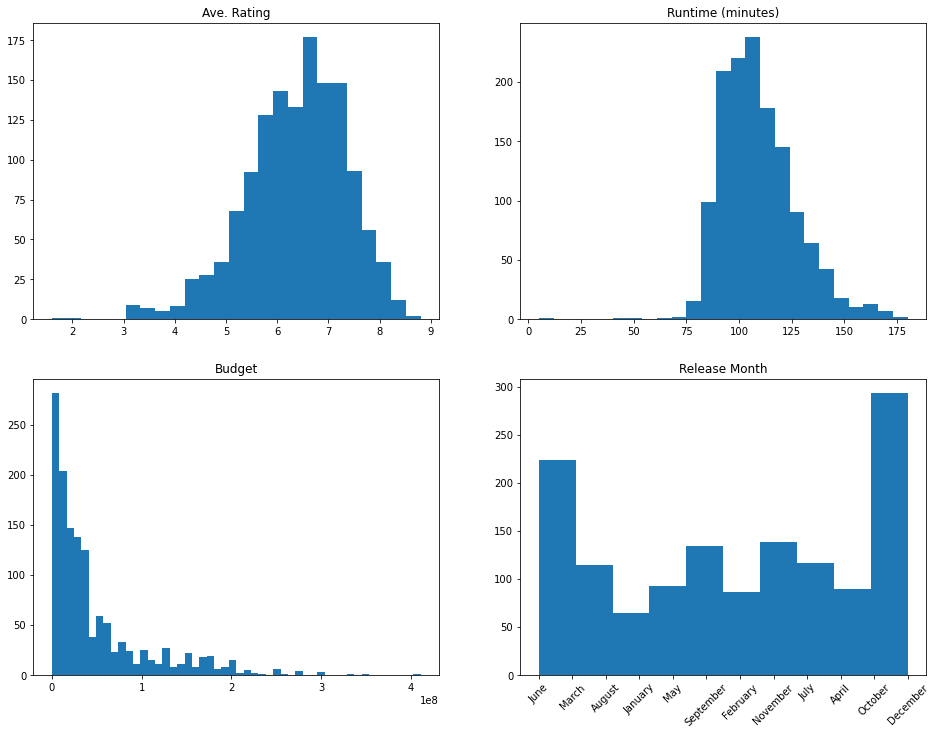

In [21]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs[0, 0].hist(imdbudget_adj.averagerating, bins=25)
axs[0, 0].set_title('Ave. Rating')
axs[0, 1].hist(imdbudget_adj.runtime_minutes, bins=25)
axs[0, 1].set_title('Runtime (minutes)')
axs[1, 0].hist(imdbudget_adj.production_budget, bins=50)
axs[1, 0].set_title('Budget')
axs[1, 1].hist(imdbudget_adj.month)
axs[1, 1].set_title('Release Month')

for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(45)

''

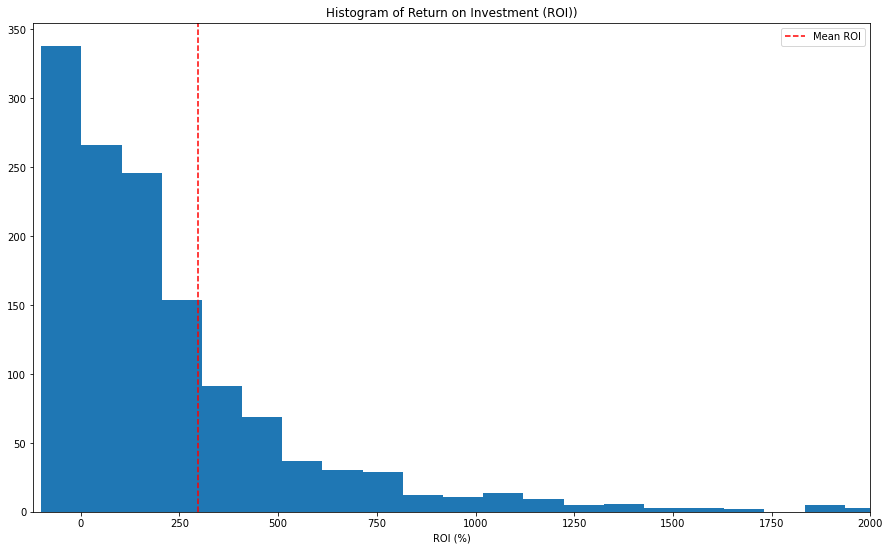

In [108]:
fig, ax = plt.subplots(figsize=(15,9))
plt.hist(imdbudget_adj.roi, bins=100)

ax.set_title('Histogram of Return on Investment (ROI))')
ax.set_xlabel('ROI (%)')
ax.set_xlim([-120, 2000])
plt.axvline(x=298, color='r', linestyle='--', label = 'Mean ROI')
plt.legend()
;

''

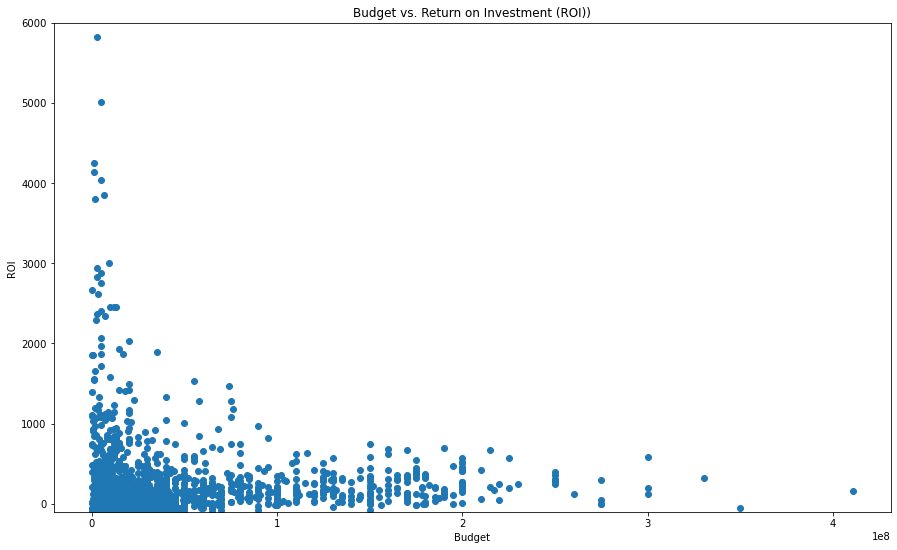

In [23]:
fig, ax = plt.subplots(figsize=(15,9))
plt.scatter(imdb_budget.production_budget,imdb_budget.roi)

ax.set_title('Budget vs. Return on Investment (ROI))')
ax.set_xlabel("Budget")
ax.set_ylabel("ROI")
ax.set_ylim([-100, 6000])
;

In [24]:
X=imdb_budget[['production_budget']]
y=imdb_budget.roi

# Create an OLS model
model = sm.OLS(endog=y, exog=sm.add_constant(X))

In [25]:
# Get model results
results = model.fit()
# Display results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.783
Date:                Mon, 03 Feb 2025   Prob (F-statistic):             0.0520
Time:                        09:57:38   Log-Likelihood:                -11609.
No. Observations:                1357   AIC:                         2.322e+04
Df Residuals:                    1355   BIC:                         2.323e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               354.6377     44.605      7.951      0.000     267.134     442.141
production_budget -1.159e-06   5.96e-07     -1.945      0.052   -2.33e-06    9.97e-09
==============================================================================
Omnibus:                     3441.795   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         41310732.792
Skew:                          26.613   Prob(JB):                         0.00
Kurtosis:                     856.107   Cond. No.                     9.79e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

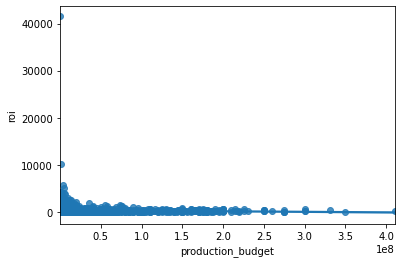

In [26]:
# Plot the model fit (scatter plot and regression line)
sns.regplot(x="production_budget",y="roi",data=imdb_budget);

''

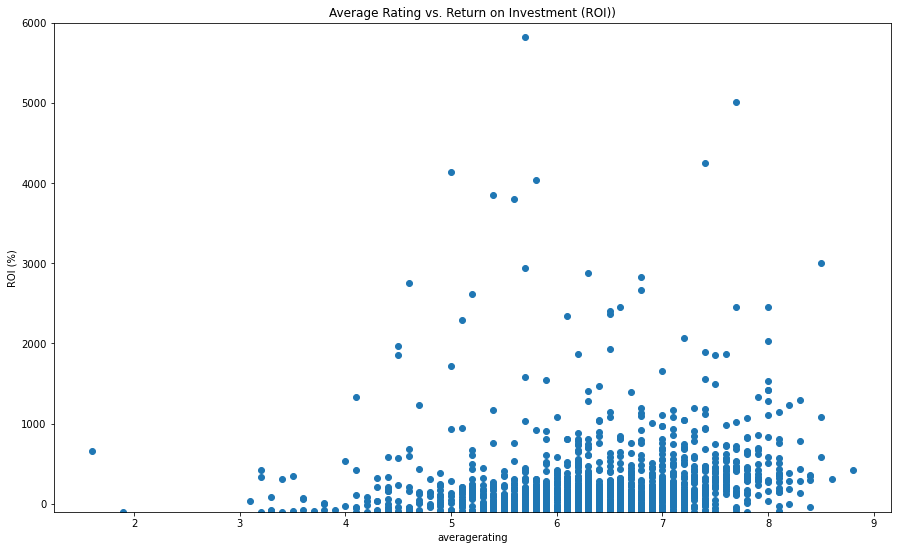

In [27]:
fig, ax = plt.subplots(figsize=(15,9))
plt.scatter(imdb_budget.averagerating,imdb_budget.roi)

ax.set_title('Average Rating vs. Return on Investment (ROI))')
ax.set_xlabel("averagerating")
ax.set_ylabel("ROI (%)")
ax.set_ylim([-100, 6000])
;

''

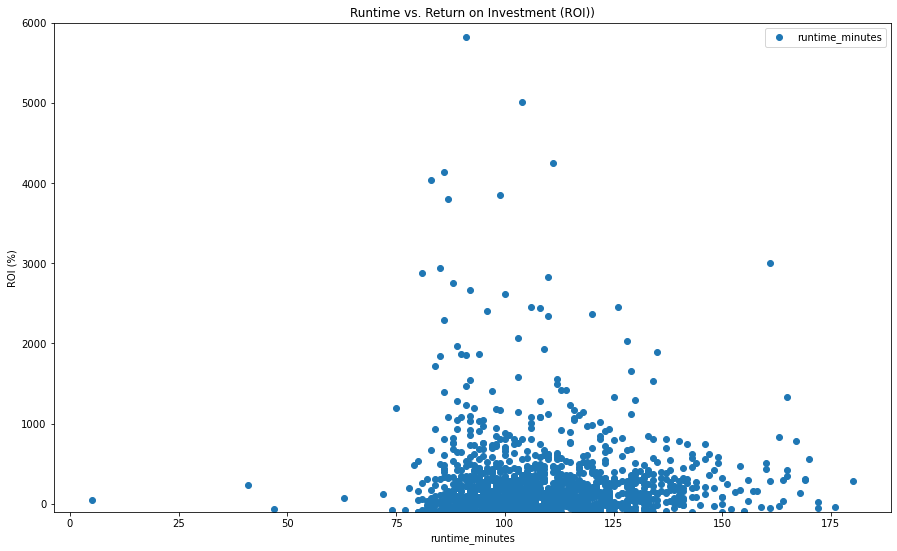

In [28]:
fig, ax = plt.subplots(figsize=(15,9))
plt.scatter(imdb_budget.runtime_minutes,imdb_budget.roi, label='runtime_minutes')

ax.set_title('Runtime vs. Return on Investment (ROI))')
ax.set_xlabel("runtime_minutes")
ax.set_ylabel("ROI (%)")
ax.set_ylim([-100, 6000])
plt.legend()

;

In [101]:
X=imdb_budget[['production_budget','averagerating', 'runtime_minutes']]
y=imdb_budget.roi

# Create an OLS model
model = sm.OLS(endog=y, exog=sm.add_constant(X))

In [102]:
# Get model results
results = model.fit()
# Display results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.085
Date:                Mon, 03 Feb 2025   Prob (F-statistic):              0.100
Time:                        10:37:11   Log-Likelihood:                -11608.
No. Observations:                1357   AIC:                         2.322e+04
Df Residuals:                    1353   BIC:                         2.324e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               526.7525    265.637      1.983      0.048       5.648    1047.857
production_budget -8.845e-07   6.36e-07     -1.390      0.165   -2.13e-06    3.64e-07
averagerating        29.1550     38.096      0.765      0.444     -45.579     103.890
runtime_minutes      -3.4123      2.192     -1.557      0.120      -7.712       0.887
==============================================================================
Omnibus:                     3443.483   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         41464456.596
Skew:                          26.645   Prob(JB):                         0.00
Kurtosis:                     857.695   Cond. No.                     5.85e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
formula = ') + C('.join([str(g) for g in genre_list])
formula = 'roi ~ C('+formula+')'+ '+runtime_minutes + averagerating + production_budget'
lm = smf.ols(formula, imdb_budget).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.402
Date:                Mon, 03 Feb 2025   Prob (F-statistic):           6.35e-08
Time:                        10:57:36   Log-Likelihood:                -11570.
No. Observations:                1357   AIC:                         2.319e+04
Df Residuals:                    1332   BIC:                         2.332e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -50.3493    334.421     -0.151      0.880    -706.399     605.701
C(Biography)[T.True]      54.1250    132.556      0.408      0.683    -205.916     314.166
C(Action)[T.True]        -67.4056     98.175     -0.687      0.492    -260.000     125.189
C(War)[T.True]          -169.9225    310.267     -0.548      0.584    -778.587     438.742
C(Western)[T.True]      -168.6119    418.615     -0.403      0.687    -989.829     652.605
C(Music)[T.True]          44.3076    193.917      0.228      0.819    -336.108     424.723
C(Reality_TV)[T.True]  -3.941e-11   8.31e-11     -0.474      0.636   -2.03e-10    1.24e-10
C(History)[T.True]       -76.5551    216.948     -0.353      0.724    -502.152     349.042
C(Game_Show)[T.True]    1.369e-10   2.89e-10      0.473      0.636   -4.31e-10    7.04e-10
C(Adventure)[T.True]      30.7994    116.438      0.265      0.791    -197.622     259.221
C(Crime)[T.True]        -209.1418    107.304     -1.949      0.051    -419.645       1.361
C(Comedy)[T.True]        -35.2039    104.576     -0.337      0.736    -240.355     169.947
C(News)[T.True]          1.88e-12   4.01e-12      0.469      0.639   -5.99e-12    9.75e-12
C(Adult)[T.True]        -4.22e-12   8.81e-12     -0.479      0.632   -2.15e-11    1.31e-11
C(Documentary)[T.True]  -169.6243    277.827     -0.611      0.542    -714.650     375.401
C(Drama)[T.True]        -137.6685    100.474     -1.370      0.171    -334.773      59.436
C(Sci_Fi)[T.True]        -91.7057    137.538     -0.667      0.505    -361.521     178.110
C(Family)[T.True]        -46.2362    150.169     -0.308      0.758    -340.830     248.357
C(Mystery)[T.True]       433.5588    135.536      3.199      0.001     167.672     699.445
C(Romance)[T.True]        46.2197    116.807      0.396      0.692    -182.927     275.366
C(Musical)[T.True]        24.4147    538.858      0.045      0.964   -1032.689    1081.518
C(Animation)[T.True]     -23.3875    166.575     -0.140      0.888    -350.165     303.390
C(Sport)[T.True]        -123.1448    234.148     -0.526      0.599    -582.483     336.193
C(Thriller)[T.True]      191.4529    113.190      1.691      0.091     -30.597     413.503
C(Horror)[T.True]        525.5296    135.040      3.892      0.000     260.615     790.444
C(Fantasy)[T.True]       -88.0263    138.111     -0.637      0.524    -358.964     182.912
runtime_minutes           -1.4870      2.497     -0.595      0.552      -6.386       3.412
averagerating             87.3151     40.429      2.160      0.031       8.003     166.627
production_budget       -5.99e-07   9.12e-07     -0.657      0.512   -2.39e-06    1.19e-06
==============================================================================
Omnibus:                     3451.613   Durbin-Watson:                   1.974
Prob(Omnibus)

In [46]:
table = sm.stats.anova_lm(lm, typ=2)
table.sort_values('PR(>F)', inplace=True, ascending=True)
print(table)

                         sum_sq      df          F    PR(>F)
C(Horror)          2.300829e+07     1.0  15.145005  0.000104
C(Mystery)         1.554548e+07     1.0  10.232677  0.001412
averagerating      7.085953e+06     1.0   4.664266  0.030975
C(Crime)           5.771200e+06     1.0   3.798841  0.051498
C(Thriller)        4.346333e+06     1.0   2.860935  0.090989
C(Drama)           2.852194e+06     1.0   1.877431  0.170857
C(Action)          7.161504e+05     1.0   0.471400  0.492463
C(Sci_Fi)          6.753976e+05     1.0   0.444574  0.505038
production_budget  6.548943e+05     1.0   0.431078  0.511574
C(Fantasy)         6.171418e+05     1.0   0.406228  0.524000
C(Documentary)     5.662958e+05     1.0   0.372759  0.541608
runtime_minutes    5.386856e+05     1.0   0.354585  0.551630
C(War)             4.556661e+05     1.0   0.299938  0.584013
C(Sport)           4.202114e+05     1.0   0.276600  0.599026
C(Adult)           3.481958e+05     1.0   0.229197  0.632199
C(Reality_TV)      3.412

In [75]:
imdbudget_genre_list = []
for value in imdb_budget['genres'].str.split(','):
    if value is not None:
        imdbudget_genre_list.extend(value)
imdbudget_genre_list = list(set(imdbudget_genre_list))
imdbudget_genre_list = [g.replace('-', '_') for g in imdbudget_genre_list]

In [91]:
# Create table of genres vs mean ROI, profit, and worldwide gross

genre_means = pd.DataFrame([(g, imdb_budget['production_budget'][imdb_budget[g]==True].mean(),
                             imdb_budget['roi'][imdb_budget[g]==True].mean(), 
                             imdb_budget['profit'][imdb_budget[g]==True].mean(), 
                             imdb_budget['worldwide_gross'][imdb_budget[g]==True].mean()) 
                            for g in imdbudget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])

genre_means = genre_means.append({'genre': 'Overall', 
                                  'budget' : imdb_budget['production_budget'].mean(),
                                  'mean_roi': imdb_budget['roi'].mean(), 
                                  'mean_profit': imdb_budget['profit'].mean(), 
                                  'mean_ww_gross': imdb_budget['worldwide_gross'].mean()
                                 }, ignore_index=True)

top_roi = genre_means.sort_values('mean_roi', ascending=False).head(4)
top_profit = genre_means.sort_values('mean_profit', ascending=False).head(3).append({'genre': 'Overall',
                                  'budget' : imdb_budget['production_budget'].mean(),
                                  'mean_roi': imdb_budget['roi'].mean(), 
                                  'mean_profit': imdb_budget['profit'].mean(), 
                                  'mean_ww_gross': imdb_budget['worldwide_gross'].mean()
                                 }, ignore_index=True)

In [92]:
genre_means.sort_values('mean_roi', ascending=False)

,genre,budget,mean_roi,mean_profit,mean_ww_gross
19,Horror,1.983247e+07,959.933922,5.887476e+07,7.870723e+07
13,Mystery,2.605498e+07,944.029296,7.069490e+07,9.674988e+07
18,Thriller,3.568454e+07,598.186551,9.246756e+07,1.281521e+08
21,Overall,4.821342e+07,298.775147,1.060221e+08,1.542355e+08
11,Sci_Fi,1.002206e+08,284.919637,2.670834e+08,3.673040e+08
16,Animation,1.001939e+08,278.690125,2.885616e+08,3.887555e+08
14,Romance,2.319897e+07,266.997046,4.729594e+07,7.049490e+07
4,Music,2.167212e+07,260.835228,8.068378e+07,1.023559e+08
0,Biography,2.645326e+07,249.716421,5.680710e+07,8.326035e+07
10,Drama,2.831032e+07,239.786746,5.072263e+07,7.903295e+07


In [93]:
top_profit

,genre,budget,mean_roi,mean_profit,mean_ww_gross
0,Animation,1.001939e+08,278.690125,2.885616e+08,3.887555e+08
1,Sci_Fi,1.002206e+08,284.919637,2.670834e+08,3.673040e+08
2,Adventure,1.092426e+08,216.977629,2.522447e+08,3.614874e+08
3,Overall,4.821342e+07,298.775147,1.060221e+08,1.542355e+08


In [94]:
top_roi

,genre,budget,mean_roi,mean_profit,mean_ww_gross
19,Horror,1.983247e+07,959.933922,5.887476e+07,7.870723e+07
13,Mystery,2.605498e+07,944.029296,7.069490e+07,9.674988e+07
18,Thriller,3.568454e+07,598.186551,9.246756e+07,1.281521e+08
21,Overall,4.821342e+07,298.775147,1.060221e+08,1.542355e+08


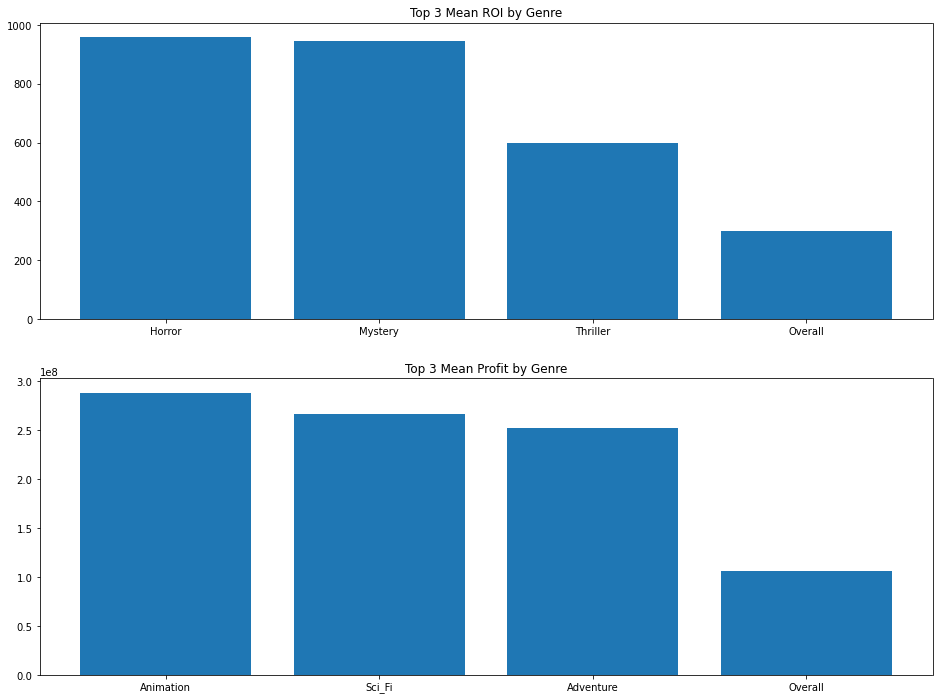

In [95]:
x= top_roi['genre']
y=top_roi['mean_roi']
fig, axs = plt.subplots(2, figsize=(16,12))
axs[0].bar(top_roi['genre'], top_roi['mean_roi'])
axs[0].set_title('Top 3 Mean ROI by Genre')
axs[1].bar(top_profit['genre'], top_profit['mean_profit'])
axs[1].set_title('Top 3 Mean Profit by Genre');

In [166]:
def genre_combos(main_genre):
    
    all_main_genre = imdb_budget[imdb_budget[main_genre]==True]
    main_genre_means = pd.DataFrame([(g, all_main_genre['production_budget'][all_main_genre[g]==True].mean(),
                                 all_main_genre['roi'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['profit'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['worldwide_gross'][all_main_genre[g]==True].mean()) 
                                for g in imdbudget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])
    main_genre_means.dropna(inplace=True)
    
    # also run analysis on rating vs genre and budget vs genre? and runtime?
    formula = 'roi ~ runtime_minutes + averagerating + production_budget'
    lm = smf.ols(formula, all_main_genre).fit()
    this_genre_summary = lm.summary()
    
    return main_genre_means.sort_values('mean_roi', ascending=False), this_genre_summary

horror_means, horror_results = genre_combos('Horror')
horror_means
horror_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.695
Date:                Mon, 03 Feb 2025   Prob (F-statistic):              0.171
Time:                        12:29:27   Log-Likelihood:                -1455.7
No. Observations:                 152   AIC:                             2919.
Df Residuals:                     148   BIC:                             2932.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5136.6740   2424.536      2.119      0.036     345.495    9927.853
runtime_minutes     -36.7785     28.293     -1.300      0.196     -92.690      19.133
averagerating       -64.5431    367.001     -0.176      0.861    -789.782     660.696
production_budget -9.655e-06   1.03e-05     -0.941      0.348   -2.99e-05    1.06e-05
==============================================================================
Omnibus:                      295.277   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74767.886
Skew:                           9.758   Prob(JB):                         0.00
Kurtosis:                     109.886   Cond. No.                     3.01e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [165]:
mystery_means, mystery_results = genre_combos('Mystery')
mystery_means
mystery_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.708
Date:                Mon, 03 Feb 2025   Prob (F-statistic):              0.169
Time:                        12:29:05   Log-Likelihood:                -1130.5
No. Observations:                 117   AIC:                             2269.
Df Residuals:                     113   BIC:                             2280.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5709.1079   2684.848      2.126      0.036     389.940     1.1e+04
runtime_minutes     -24.8325     28.912     -0.859      0.392     -82.112      32.447
averagerating      -325.1894    437.411     -0.743      0.459   -1191.780     541.401
production_budget -4.455e-06   1.47e-05     -0.302      0.763   -3.36e-05    2.47e-05
==============================================================================
Omnibus:                      236.070   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44467.396
Skew:                           9.375   Prob(JB):                         0.00
Kurtosis:                      96.648   Cond. No.                     3.05e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [164]:
thriller_means, thrill_results = genre_combos('Thriller')
thriller_means
thrill_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.760
Date:                Mon, 03 Feb 2025   Prob (F-statistic):              0.156
Time:                        12:28:46   Log-Likelihood:                -2169.0
No. Observations:                 232   AIC:                             4346.
Df Residuals:                     228   BIC:                             4360.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3303.4794   1454.528      2.271      0.024     437.443    6169.516
runtime_minutes     -18.9322     15.003     -1.262      0.208     -48.494      10.630
averagerating      -101.0572    210.434     -0.480      0.632    -515.701     313.587
production_budget -1.873e-06   4.95e-06     -0.378      0.706   -1.16e-05    7.89e-06
==============================================================================
Omnibus:                      486.732   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           340485.203
Skew:                          13.088   Prob(JB):                         0.00
Kurtosis:                     188.842   Cond. No.                     4.47e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [169]:
def genre_combos_profit(main_genre):
    
    all_main_genre = imdb_budget[imdb_budget[main_genre]==True]
    main_genre_means = pd.DataFrame([(g, all_main_genre['production_budget'][all_main_genre[g]==True].mean(),
                                 all_main_genre['roi'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['profit'][all_main_genre[g]==True].mean(), 
                                 all_main_genre['worldwide_gross'][all_main_genre[g]==True].mean()) 
                                for g in imdbudget_genre_list], columns=['genre','budget','mean_roi','mean_profit', 'mean_ww_gross'])
    main_genre_means.dropna(inplace=True)
    
    # also run analysis on rating vs genre and budget vs genre? and runtime?
    formula = 'profit ~ runtime_minutes + averagerating + production_budget'
    lm = smf.ols(formula, all_main_genre).fit()
    this_genre_summary = lm.summary()
    
    return main_genre_means.sort_values('mean_profit', ascending=False), this_genre_summary

animation_means, anim_results = genre_combos_profit('Animation')
print(animation_means)
anim_results

        genre        budget    mean_roi   mean_profit  mean_ww_gross
1      Action  1.142500e+08  248.862486  3.069505e+08   4.212005e+08
6   Adventure  1.045632e+08  276.030407  2.962842e+08   4.008474e+08
8      Comedy  9.753205e+07  298.556991  2.929458e+08   3.904779e+08
16  Animation  1.001939e+08  278.690125  2.885616e+08   3.887555e+08
12     Family  6.405000e+07  237.259701  1.794857e+08   2.435357e+08
10      Drama  8.000000e+06  -28.672900 -2.293832e+06   5.706168e+06


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     13.12
Date:                Mon, 03 Feb 2025   Prob (F-statistic):           3.16e-07
Time:                        12:32:05   Log-Likelihood:                -2028.0
No. Observations:                  98   AIC:                             4064.
Df Residuals:                      94   BIC:                             4074.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -6.326e+08   3.26e+08     -1.939      0.055   -1.28e+09    1.51e+07
runtime_minutes     3.92e+06   3.72e+06      1.054      0.295   -3.47e+06    1.13e+07
averagerating      5.665e+07   2.64e+07      2.144      0.035    4.18e+06    1.09e+08
production_budget     1.7657      0.551      3.205      0.002       0.672       2.859
==============================================================================
Omnibus:                       32.868   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.904
Skew:                           1.421   Prob(JB):                     4.40e-13
Kurtosis:                       5.420   Cond. No.                     1.53e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

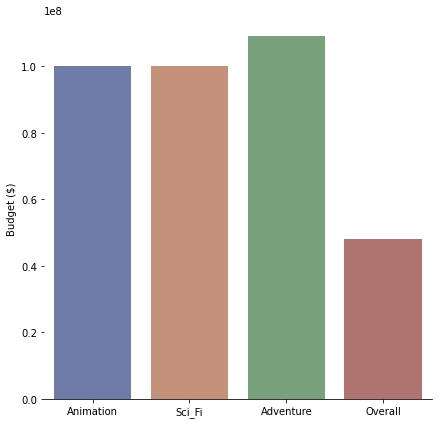

In [145]:
g = sns.catplot(
    data=top_profit, kind="bar",
    x="genre", y="budget",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Budget ($)")
# g.legend.set_title("")

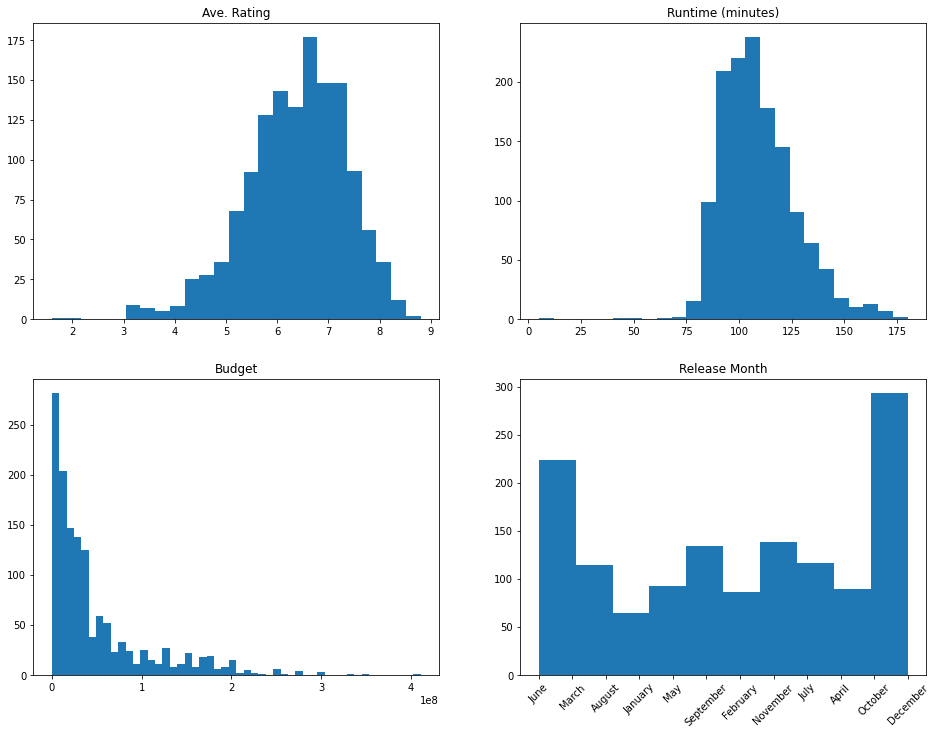

In [39]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
axs[0, 0].hist(imdbudget_adj.averagerating, bins=25)
axs[0, 0].set_title('Ave. Rating')
axs[0, 1].hist(imdbudget_adj.runtime_minutes, bins=25)
axs[0, 1].set_title('Runtime (minutes)')
axs[1, 0].hist(imdbudget_adj.production_budget, bins=50)
axs[1, 0].set_title('Budget')
axs[1, 1].hist(imdbudget_adj.month)
axs[1, 1].set_title('Release Month')

for tick in axs[1, 1].get_xticklabels():
    tick.set_rotation(45)

Data Preparation

Modeling

Evaluation

Deployment

In [40]:
# budget.drop_duplicates(subset=['movie','year'],, keep=False inplace=True)
# budget[budget.movie.duplicated(keep=False)].sort_values('movie')

In [41]:
# There is one duplicate movie title. I will 

# budget.drop_duplicates(subset=['movie','year'], inplace=True)
# budget

In [42]:
# imdb[imdb['primary_title'].str.contains( 'The Promise')]
# # budget.reset_index(inplace=True)
# # budget[budget['title'].str.contains( 'The Promise')]

In [43]:
# budget[budget.index.duplicated(keep=False)].sort_values('movie').head(50)

In [44]:
# imdb.reset_index(inplace=True)
# imdb.drop_duplicates(subset=['title','year'], keep=False)


# budget[budget.index.duplicated(keep=False)]

In [45]:
# gross[gross.index.duplicated(keep=False)].sort_values('title').head(50)
# gross.drop_duplicates(subset='title', inplace=True)